In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from data import *
from baseline_smc import *
from plots import *
from torch.distributions.dirichlet import Dirichlet
import sys
import datetime
import time 
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.5.0a0+3bb8c5e cuda: True


In [2]:
## Dataset parameters
num_series = 1
## range of length of tracjectories, need to be positive integers
T_min = 50
T_max = 60
K = 4
D = 2
dt = 5
Boundary = 30
noise_ratio = 10.0

## Model Parameters
num_particles = 50
num_particles_smc = 30
NUM_HIDDEN = 32
NUM_LATENTS = K*K
NUM_OBS = 2 * K

NUM_EPOCHS = 1000
LEARNING_RATE = 1e-3
CUDA = False
RESTORE = False
PATH_ENC = "baseline/1shot_enc-%dIS-enc-%s" % (num_particles, datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

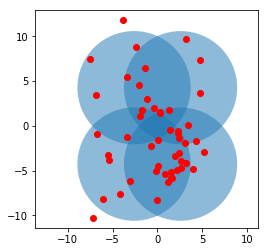

In [3]:
T = 50
noise_cov = np.array([[1, 0], [0, 1]]) * noise_ratio       
init_v = np.random.random(2) * np.random.choice([-1,1], size=2)
v_norm = ((init_v ** 2 ).sum()) ** 0.5 ## compute norm for each initial velocity
init_v = init_v / v_norm * dt ## to make the velocity lying on a circle
STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)

plot_clusters(Y.data.numpy(), mu_ks.data.numpy(), cov_ks.data.numpy(), K)

In [4]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, prior):
        A_sample = torch.zeros((K, K))
        hidden = self.enc_hidden(obs)
        variational = F.softmax(self.latent_dir(hidden), -1).sum(0).view(K, K) + prior
        for k in range(K):
            A_sample[k] = Dirichlet(variational[k]).sample()
        return variational, A_sample

In [5]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer
enc, optimizer = initialize()

In [6]:
KLs = []
EUBOs = []
ESSs = []
ELBOs = []

for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    optimizer.zero_grad()
    alpha_trans_0 = initial_trans_prior(K)
    init_v = init_velocity(dt)
    T = np.random.randint(T_min, T_max)
    STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)
    eubo, kl, ess, variational, elbo = oneshot_sharp_prior(enc, alpha_trans_0, Pi, mu_ks, cov_ks, Y, T, D, K, num_particles, num_particles_smc)
    eubo.backward()
    KLs.append(kl.item())
    EUBOs.append(eubo.item())
    ELBOs.append(elbo.item())
    ESSs.append(ess)
#     log_qs.append(loss_infer.item())
    optimizer.step()
    time_end = time.time()
    print('epoch : %d, eubo : %f, elbo : %f, KL : %f (%ds)' % (epoch, eubo, elbo, kl, time_end - time_start))

# if RESTORE:
#     enc.load_state_dict(torch.load(PATH_ENC))
# else:
#     torch.save(enc.state_dict(), PATH_ENC)
#     save_params(KLs, EUBOs, ESSs, PATH_ENC)

epoch : 0, eubo : -287.264313, elbo : -290.169037, KL : 26.477184 (1s)
epoch : 1, eubo : -277.826813, elbo : -281.094299, KL : 29.932335 (1s)
epoch : 2, eubo : -330.797791, elbo : -337.623169, KL : 31.435667 (1s)
epoch : 3, eubo : -283.338501, elbo : -287.828918, KL : 36.880833 (1s)
epoch : 4, eubo : -289.542908, elbo : -293.997345, KL : 24.476557 (1s)
epoch : 5, eubo : -291.782227, elbo : -295.420380, KL : 36.171154 (1s)
epoch : 6, eubo : -313.392456, elbo : -317.722198, KL : 29.269203 (2s)
epoch : 7, eubo : -302.237701, elbo : -305.274323, KL : 27.474695 (1s)
epoch : 8, eubo : -330.661621, elbo : -334.846802, KL : 32.699337 (1s)
epoch : 9, eubo : -324.810181, elbo : -330.972260, KL : 30.695066 (1s)
epoch : 10, eubo : -306.860901, elbo : -311.768463, KL : 36.058197 (1s)
epoch : 11, eubo : -320.906738, elbo : -323.699738, KL : 32.588490 (2s)
epoch : 12, eubo : -324.415344, elbo : -331.174683, KL : 36.411259 (1s)
epoch : 13, eubo : -319.329834, elbo : -323.635315, KL : 25.150511 (1s)
ep

In [7]:
# plot_dirs(variational, alpha_trans_0, Zs_true, T, K, vmax=15)

In [8]:
# conjugate_post = alpha_trans_0 + pairwise(Z_true, T).sum(0)
# variational = alpha_trans_0 + latents_dirs
# conjugate_post.sum()

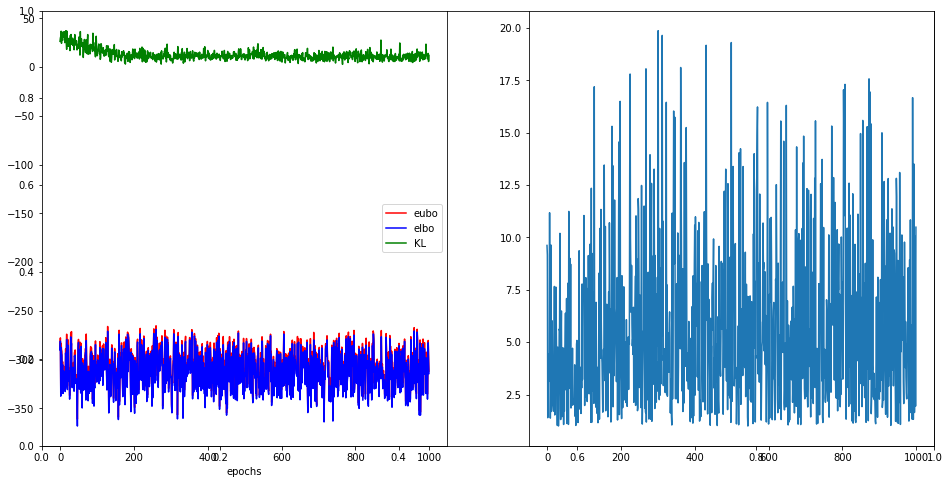

In [9]:
plot_results(EUBOs, ELBOs, KLs, ESSs, PATH_ENC)

In [10]:
alpha_trans_0 = initial_trans_prior(K)
init_v = init_velocity(dt)
T = np.random.randint(T_min, T_max)
STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)

Zs, log_weights, log_normalizer = smc_hmm(Pi, A_true, mu_ks, cov_ks, Y, T, D, K, num_particles_smc)
Z_true = resampling_smc(Zs, log_weights)

In [ ]:
accuracy = []
for i in range(1000):
    alpha_trans_0 = initial_trans_prior(K)
    init_v = init_velocity(dt)
    T = np.random.randint(T_min, T_max)
    STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)
    
    A_samples = initial_trans(alpha_trans_0, K)
    Zs, log_weights, log_normalizer = smc_hmm(Pi, A_samples, mu_ks, cov_ks, Y, T, D, K, num_particles_smc)
    Z_ret = resampling_smc(Zs, log_weights)
    Z_ret_pairwise = torch.cat((Z_ret[:T-1].unsqueeze(0), Z_ret[1:].unsqueeze(0)), 0).transpose(0, 1).contiguous().view(T-1, 2*K)
    variational_curr, A_samples = enc(Z_ret_pairwise, alpha_trans_0)
    Zs, log_weights, log_normalizer = csmc_hmm(Z_ret, Pi, A_samples, mu_ks, cov_ks, Y, T, D, K, num_particles_smc)
    Z_ret = resampling_smc(Zs, log_weights)

    accuracy.append((Zs_true.nonzero()[:, 1] == Z_ret.nonzero()[:, 1]).sum().float().item() / T)

In [ ]:
torch.cat((Z_true, Y), -1)